### Load libraries and set global parameters

In [1]:
## import warnings
import numpy as np
import pandas as pd
import yfinance as yf

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pylab import rcParams
rcParams["lines.linewidth"]=2
plt.style.use('ggplot')

### Download data from Yahoo! Finance and inspect the output

In [2]:
symbol = "FB AMZN AAPL MSFT "
data = yf.download(symbol, start="2008-10-01", end="2019-09-30")

data.head()

[*********************100%***********************]  4 of 4 downloaded


Adj Close                    Close                     High         \
                AAPL   AMZN  FB   MSFT   AAPL   AMZN  FB   MSFT   AAPL   AMZN   
Date                                                                            
2008-10-01     13.60  69.58 NaN  20.30  15.59  69.58 NaN  26.48  16.05  71.99   
2008-10-02     12.48  67.36 NaN  20.12  14.30  67.36 NaN  26.25  15.54  68.96   
2008-10-03     12.10  67.00 NaN  20.17  13.87  67.00 NaN  26.32  15.21  70.95   
2008-10-06     12.24  65.23 NaN  19.09  14.02  65.23 NaN  24.91  14.11  65.89   
2008-10-07     11.12  58.52 NaN  17.81  12.74  58.52 NaN  23.23  14.50  66.43   

            ... Low          Open                       Volume                \
            ...  FB   MSFT   AAPL   AMZN  FB   MSFT       AAPL      AMZN  FB   
Date        ...                                                                
2008-10-01  ... NaN  26.28  15.99  71.78 NaN  26.38  324121000   9622200 NaN   
2008-10-02  ... NaN  25.70  15.43  67.63 NaN  26.18  402341100   8726100 NaN   
2008-10-03  ... NaN  26.24  14.86  69.42 NaN  26.37  573599600  11228100 NaN   
2008-10-06  ... NaN  24.14  13.14  64.06 NaN  25.63  526854300  13385500 NaN   
2008-10-07  ... NaN  23.14  14.35  65.79 NaN  24.98  469693000  12756000 NaN   

                       
                 MSFT  
Date                   
2008-10-01   88957000  
2008-10-02   93819800  
2008-10-03  114289400  
2008-10-06  146374600  
2008-10-07  145941200  

[5 rows x 24 columns]

### Check for any missing datapoints
- Note, FB data is partially filled as it did not traded publicly (or IPO) until 2012

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2768 entries, 2008-10-01 to 2019-09-30
Data columns (total 24 columns):
(Adj Close, AAPL)    2768 non-null float64
(Adj Close, AMZN)    2768 non-null float64
(Adj Close, FB)      1853 non-null float64
(Adj Close, MSFT)    2768 non-null float64
(Close, AAPL)        2768 non-null float64
(Close, AMZN)        2768 non-null float64
(Close, FB)          1853 non-null float64
(Close, MSFT)        2768 non-null float64
(High, AAPL)         2768 non-null float64
(High, AMZN)         2768 non-null float64
(High, FB)           1853 non-null float64
(High, MSFT)         2768 non-null float64
(Low, AAPL)          2768 non-null float64
(Low, AMZN)          2768 non-null float64
(Low, FB)            1853 non-null float64
(Low, MSFT)          2768 non-null float64
(Open, AAPL)         2768 non-null float64
(Open, AMZN)         2768 non-null float64
(Open, FB)           1853 non-null float64
(Open, MSFT)         2768 non-null float64
(Volume, AAPL) 

### Resample data to Monthly from Daily by taking the Monthly mean

In [4]:
data = data.resample("M").mean()

data.head()

Adj Close                                Close                 \
                 AAPL       AMZN  FB       MSFT       AAPL       AMZN  FB   
Date                                                                        
2008-10-31  12.343043  56.410000 NaN  18.013478  14.143913  56.410000 NaN   
2008-11-30  11.712632  44.413158 NaN  15.798947  13.420526  44.413158 NaN   
2008-12-31  11.413182  49.463182 NaN  15.059545  13.078182  49.463182 NaN   
2009-01-31  11.068500  52.317000 NaN  14.595000  12.682000  52.317000 NaN   
2009-02-28  11.728947  63.426316 NaN  14.076316  13.438421  63.426316 NaN   

                            High             ... Low                  Open  \
                 MSFT       AAPL       AMZN  ...  FB       MSFT       AAPL   
Date                                         ...                             
2008-10-31  23.500435  14.823913  59.640000  ... NaN  22.723478  14.243478   
2008-11-30  20.555263  13.817368  46.450526  ... NaN  20.023158  13.498947   
2008-12-31  19.516818  13.346818  50.940000  ... NaN  19.110000  13.044091   
2009-01-31  18.914000  12.929500  53.554500  ... NaN  18.585500  12.666500   
2009-02-28  18.183684  13.696842  64.694737  ... NaN  17.827895  13.384737   

                                            Volume                    \
                 AMZN  FB       MSFT          AAPL          AMZN  FB   
Date                                                                   
2008-10-31  56.279565 NaN  23.634783  4.502903e+08  1.443803e+07 NaN   
2008-11-30  44.720526 NaN  20.662632  3.107824e+08  1.200271e+07 NaN   
2008-12-31  49.028182 NaN  19.498636  2.297028e+08  9.372468e+06 NaN   
2009-01-31  52.013500 NaN  18.983500  2.263218e+08  1.020362e+07 NaN   
2009-02-28  62.865263 NaN  18.175789  1.824665e+08  9.830537e+06 NaN   

                          
                    MSFT  
Date                      
2008-10-31  1.323730e+08  
2008-11-30  9.446904e+07  
2008-12-31  7.031561e+07  
2009-01-31  7.820217e+07  
2009-02-28  7.664281e+07  

[5 rows x 24 columns]

### Unstack the symbols to be their own column

In [5]:
df = data.stack().reset_index().rename(index=str, columns={"level_1": "Symbol"}).sort_values(['Symbol','Date'])
df = df.set_index("Date")
df.columns = df.columns.str.lower()

df.head()

,symbol,adj close,close,high,low,open,volume
Date,,,,,,,
2008-10-31,AAPL,12.343043,14.143913,14.823913,13.491739,14.243478,4.502903e+08
2008-11-30,AAPL,11.712632,13.420526,13.817368,13.047368,13.498947,3.107824e+08
2008-12-31,AAPL,11.413182,13.078182,13.346818,12.763636,13.044091,2.297028e+08
2009-01-31,AAPL,11.068500,12.682000,12.929500,12.441500,12.666500,2.263218e+08
2009-02-28,AAPL,11.728947,13.438421,13.696842,13.185789,13.384737,1.824665e+08


### Partition the dataframe into train and test dataframes

In [6]:
train_df = df["2008-10-01":"2018-09-30"]
test_df = df["2018-10-01":"2019-09-30"]

train_df.tail()

,symbol,adj close,close,high,low,open,volume
Date,,,,,,,
2018-05-31,MSFT,94.911818,96.981364,97.535455,95.977273,96.632727,2.315536e+07
2018-06-30,MSFT,98.626190,100.561905,101.332857,99.857619,100.665714,2.869453e+07
2018-07-31,MSFT,102.624286,104.638571,105.455714,103.665238,104.585714,2.711201e+07
2018-08-31,MSFT,106.823913,108.684348,109.203478,107.850870,108.453913,1.985340e+07
2018-09-30,MSFT,110.502105,112.237895,112.946316,111.212105,112.077368,2.527661e+07


### Convert dataframe to be an Apple stock specific dataframe

In [7]:
stock_train = train_df.loc[train_df.symbol=="AAPL"]
stock_test = test_df.loc[test_df.symbol=="AAPL"]

stock_train.tail()

,symbol,adj close,close,high,low,open,volume
Date,,,,,,,
2018-05-31,AAPL,181.815455,185.536818,186.469091,183.862273,184.956364,2.822620e+07
2018-06-30,AAPL,185.090476,188.621429,189.831905,187.419048,188.720476,2.512498e+07
2018-07-31,AAPL,186.749048,190.311429,191.540000,189.014762,190.196190,1.874721e+07
2018-08-31,AAPL,209.869565,213.346087,214.561304,211.305652,212.486957,3.044865e+07
2018-09-30,AAPL,218.679474,222.073684,224.530526,220.077895,222.331053,3.573537e+07


### Visually check if time series data is stationary

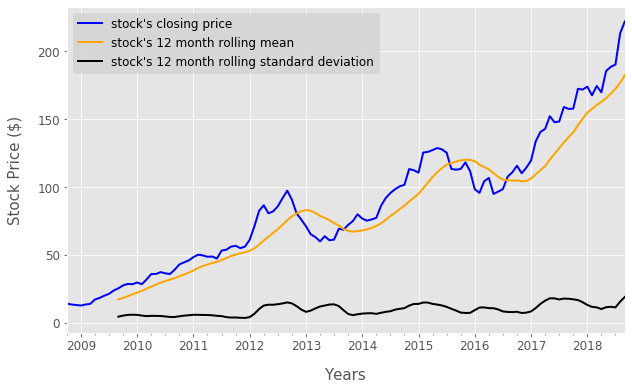

In [8]:
pd.plotting.register_matplotlib_converters()

fig = plt.figure(figsize=(10,6))

stock_train.close.plot(color="blue", label="stock's closing price")

stock_rolling_mean = stock_train.close.rolling(window=12).mean()
stock_rolling_std = stock_train.close.rolling(window=12).std()

stock_rolling_mean.plot(color="orange", label="stock's 12 month rolling mean")
stock_rolling_std.plot(color="black", label="stock's 12 month rolling standard deviation")

plt.xlabel("Years", labelpad=15, fontsize=15)
plt.ylabel("Stock Price ($)", labelpad=15, fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc="best", facecolor="lightgrey", fontsize=12)

plt.show()

### Decompose time series into its additive components

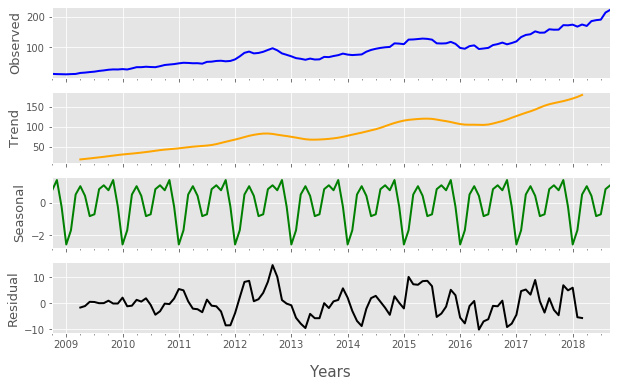

In [9]:
rcParams['figure.figsize'] = 10, 6

stock_decomposition = seasonal_decompose(stock_train.close, model="additive", freq=12)

fig, ax = plt.subplots(4, 1, sharex=True)

stock_decomposition.observed.plot(ax=ax[0], legend=False, color='blue')
ax[0].set_ylabel("Observed", fontsize=13)
stock_decomposition.trend.plot(ax=ax[1], legend=False, color='orange')
ax[1].set_ylabel("Trend", fontsize=13)
stock_decomposition.seasonal.plot(ax=ax[2], color="green", legend=False)
ax[2].set_ylabel("Seasonal", fontsize=13)
stock_decomposition.resid.plot(ax=ax[3], legend=False, color='black')
ax[3].set_ylabel("Residual", fontsize=13)

plt.xlabel("Years", labelpad=15, fontsize=15)

plt.show()

### Confirm time series data is stationary with the Dicky-Fuller test

In [10]:
stock_close_adf = adfuller(stock_train.close)

stock_adf_summary = pd.Series(stock_close_adf[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

for key,value in stock_close_adf[4].items():
    stock_adf_summary['Critical Value (%s)'%key] = value

print('Results of Dickey-Fuller Test:')
print(stock_adf_summary)

Results of Dickey-Fuller Test:
Test Statistic                   1.685822
p-value                          0.998094
#Lags Used                       0.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


### Convert the time series data to be stationary and inspect the outputs

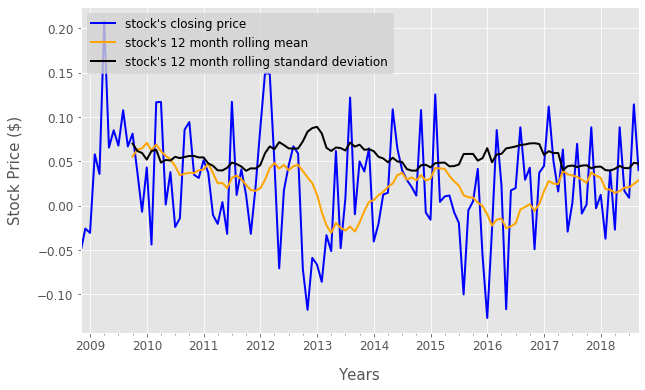

In [11]:
stock_log = np.log(stock_train.close).dropna()
stock_diff = stock_log.diff().dropna()

fig = plt.figure(figsize=(10,6))

stock_diff.plot(color="blue", label="stock's closing price")

stock_rolling_log_mean = stock_diff.rolling(window=12).mean()
stock_rolling_log_std = stock_diff.rolling(window=12).std()

stock_rolling_log_mean.plot(color="orange", label="stock's 12 month rolling mean")
stock_rolling_log_std.plot(color="black", label="stock's 12 month rolling standard deviation")

plt.xlabel("Years", labelpad=15, fontsize=15)
plt.ylabel("Stock Price ($)", labelpad=15, fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc="upper left", facecolor="lightgrey", fontsize=12)

plt.show()

### Check how the decomposition appears now for each component

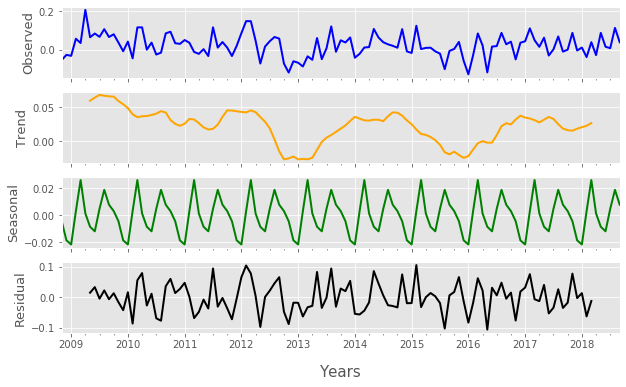

In [12]:
rcParams['figure.figsize'] = 10, 6

stock_decomposition = seasonal_decompose(stock_diff, model="additive", freq=12)

fig, ax = plt.subplots(4, 1, sharex=True)

stock_decomposition.observed.plot(ax=ax[0], legend=False, color='blue')
ax[0].set_ylabel("Observed", fontsize=13)
stock_decomposition.trend.plot(ax=ax[1], legend=False, color='orange')
ax[1].set_ylabel("Trend", fontsize=13)
stock_decomposition.seasonal.plot(ax=ax[2], color="green", legend=False)
ax[2].set_ylabel("Seasonal", fontsize=13)
stock_decomposition.resid.plot(ax=ax[3], legend=False, color='black')
ax[3].set_ylabel("Residual", fontsize=13)

plt.xlabel("Years", labelpad=15, fontsize=15)

plt.show()

### Confirm time series data is stationary now

In [13]:
stock_transform_adf = adfuller(stock_diff)

stock_transform_summary = pd.Series(stock_transform_adf[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in stock_transform_adf[4].items():
    stock_transform_summary['Critical Value (%s)'%key] = value
    
print('Results of Dickey-Fuller Test:')   
print(stock_transform_summary)

Results of Dickey-Fuller Test:
Test Statistic                -8.235947e+00
p-value                        5.889858e-13
#Lags Used                     0.000000e+00
Number of Observations Used    1.180000e+02
Critical Value (1%)           -3.487022e+00
Critical Value (5%)           -2.886363e+00
Critical Value (10%)          -2.580009e+00
dtype: float64
